In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score,  classification_report
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
import ipaddress

import warnings
warnings.simplefilter('ignore')

In [36]:
#DATADIR = '/home/infres/abiapo/prim/data'
DATADIR = '/home/infres/sagbo-21/Documents/PRIM/PRIM/data'

In [3]:
data = pd.read_csv(DATADIR+'/balance_mix_data.csv')
data.head()

,Unnamed:_0,Flow_ID,Source_IP,Source_Port,Destination_IP,Destination_Port,Protocol,Timestamp,Flow_Duration,Total_Fwd_Packets,...,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,SimillarHTTP,Inbound,Label,label
0,112140,172.16.0.5-192.168.50.1-44231-8387-17,172.16.0.5,44231,192.168.50.1,8387,17,2018-12-01 13:45:46.994571,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,TFTP,1
1,25309,172.16.0.5-192.168.50.1-891-63192-17,172.16.0.5,891,192.168.50.1,63192,17,2018-12-01 12:14:48.493601,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_SNMP,1
2,3538,172.16.0.5-192.168.50.1-649-33920-17,172.16.0.5,649,192.168.50.1,33920,17,2018-12-01 10:36:57.214865,1620,126,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_NTP,1
3,11531,192.168.10.50-192.168.50.6-22-56370-6,192.168.50.6,56370,192.168.10.50,22,6,2018-11-03 12:46:39.696861,8996366,6,...,2995940.0,2995940.0,6000423.0,0.0,6000423.0,6000423.0,0,1,BENIGN,0
4,1489,192.168.50.6-4.2.2.4-58840-53-17,192.168.50.6,58840,4.2.2.4,53,17,2018-12-01 10:59:03.241570,20681,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,BENIGN,0


In [4]:
data = data.drop(['Unnamed:_0'],axis=1)

In [5]:
data['Source_IP'] = data['Source_IP'].apply(lambda ip: int(ipaddress.ip_address(ip)))
data['Destination_IP'] = data['Destination_IP'].apply(lambda ip: int(ipaddress.ip_address(ip)))

In [6]:
data = data.drop(['Flow_ID'],axis=1)

In [7]:
data = data.drop(['Timestamp'],axis=1)

SimilarHTTP has a different structure. Maybe we could perform a wordembedding to transform the string to numerical value. For the moment we will delete this feature.

In [ ]:
data = data.drop(['SimillarHTTP'],axis=1)

In [11]:
data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

In [12]:
X = data.iloc[:,:-2]
y = data.iloc[:,-1].to_numpy()

In [13]:
all(X>0)

True

In [14]:
X.iloc[:,[35,36,37,47,50,54,60,61,62,63,64,65]]

,Bwd_PSH_Flags,Fwd_URG_Flags,Bwd_URG_Flags,FIN_Flag_Count,PSH_Flag_Count,ECE_Flag_Count,Fwd_Avg_Bytes_Bulk,Fwd_Avg_Packets_Bulk,Fwd_Avg_Bulk_Rate,Bwd_Avg_Bytes_Bulk,Bwd_Avg_Packets_Bulk,Bwd_Avg_Bulk_Rate
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
218537,0,0,0,0,0,0,0,0,0,0,0,0
218538,0,0,0,0,0,0,0,0,0,0,0,0
218539,0,0,0,0,0,0,0,0,0,0,0,0
218540,0,0,0,0,0,0,0,0,0,0,0,0


# Feature selection : Filter Methods

**Definition**
Filter methods select features from a dataset independently for any machine learning algorithm. 
These methods rely only on the characteristics of these variables, so features are filtered out of the data before learning begins.
These methods are powerful and simple and help to quickly remove features— and they are generally the first step in any feature selection pipeline

**Avantages**
- Selected features can be used in any machine learning algorithm,
- They’re computationally inexpensive—you can process thousands of features in a matter of seconds.

Filter methods are very good for eliminating irrelevant, redundant, constant, duplicated, and correlated features.

## Statistical & Ranking Filter Methods

These methods are statistical tests that evaluate each feature individually. By shedding light on the target, they evaluate whether the variable is important in order to discriminate against the target.
Essentially, these methods rank the features based on certain criteria or metrics and then select the features with the highest ranking.

### ANOVA Univariate Test

A univariate test, or more specifically ANOVA ( — short for ANalysis Of VAriance), is similar to the previous scores, as it measures the dependence of two variables.
ANOVA assumes a linear relationship between the variables and the target, and also that the variables are normally distributed.

In [15]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, RFE, SelectFromModel

In [16]:
#Select top 2 features based on f_classif
selector = SelectKBest(f_classif, k = 20).fit(X, y)
dfscores = pd.DataFrame(selector.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [17]:
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
featureScores.head()

,Specs,Score
0,Source_IP,3088.218495
1,Source_Port,14484.364758
2,Destination_IP,131892.416410
3,Destination_Port,69646.428307
4,Protocol,116197.690449


In [18]:
print(featureScores.nlargest(20,'Score'))

                     Specs          Score
82                 Inbound  462266.190790
42       Min_Packet_Length  177346.597914
11   Fwd_Packet_Length_Min  175117.476648
12  Fwd_Packet_Length_Mean  157338.314600
57    Avg_Fwd_Segment_Size  157338.314600
56     Average_Packet_Size  131976.869431
2           Destination_IP  131892.416410
44      Packet_Length_Mean  130341.451580
4                 Protocol  116197.690449
52          URG_Flag_Count   88834.372220
55           Down_Up_Ratio   81668.099475
40           Fwd_Packets_s   80583.814754
19          Flow_Packets_s   79184.437235
18            Flow_Bytes_s   76059.089470
3         Destination_Port   69646.428307
10   Fwd_Packet_Length_Max   57386.778973
15   Bwd_Packet_Length_Min   34612.381219
53          CWE_Flag_Count   27753.063947
16  Bwd_Packet_Length_Mean   19628.956456
58    Avg_Bwd_Segment_Size   19628.956456


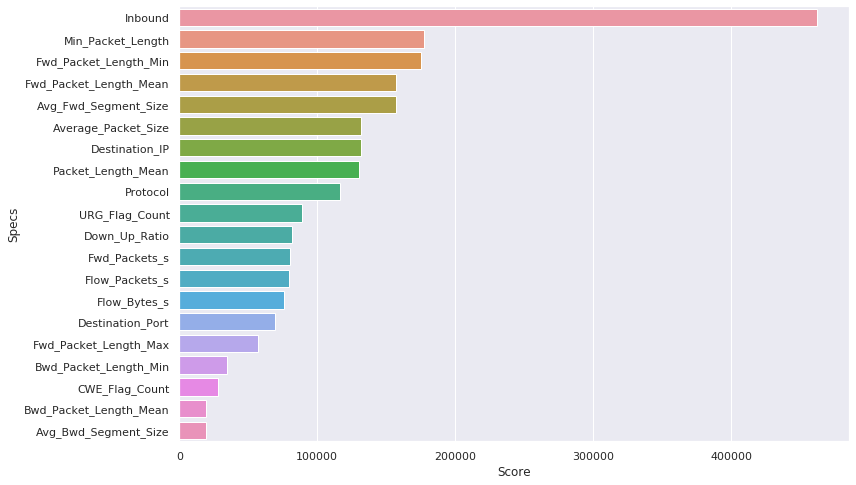

In [19]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(data = featureScores.nlargest(20,'Score'), x = "Score", y = "Specs")

### Mutual Information
Mutual information a measure of the mutual dependence of two variables. It measures the amount of information obtained about one variable through observing the other variable. In other words, it determines how much we can know about one variable by understanding another—it’s a little bit like correlation, but mutual information is more general.


In [21]:
#Select top 2 features based on mutual_info_classif
selector = SelectKBest(mutual_info_classif, k = 20).fit(X, y)
dfscores = pd.DataFrame(selector.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [22]:
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
featureScores.head()

,Specs,Score
0,Source_IP,0.707124
1,Source_Port,0.435841
2,Destination_IP,0.695366
3,Destination_Port,0.544799
4,Protocol,0.216677


In [23]:
print(featureScores.nlargest(20,'Score'))

                          Specs     Score
0                     Source_IP  0.707124
2                Destination_IP  0.695366
56          Average_Packet_Size  0.594324
42            Min_Packet_Length  0.579059
57         Avg_Fwd_Segment_Size  0.578970
44           Packet_Length_Mean  0.578718
12       Fwd_Packet_Length_Mean  0.578700
11        Fwd_Packet_Length_Min  0.577470
43            Max_Packet_Length  0.561941
18                 Flow_Bytes_s  0.559120
8   Total_Length_of_Fwd_Packets  0.555750
67            Subflow_Fwd_Bytes  0.555084
3              Destination_Port  0.544799
10        Fwd_Packet_Length_Max  0.541167
19               Flow_Packets_s  0.462307
40                Fwd_Packets_s  0.457755
22                 Flow_IAT_Max  0.452783
20                Flow_IAT_Mean  0.447246
82                      Inbound  0.446021
5                 Flow_Duration  0.442198


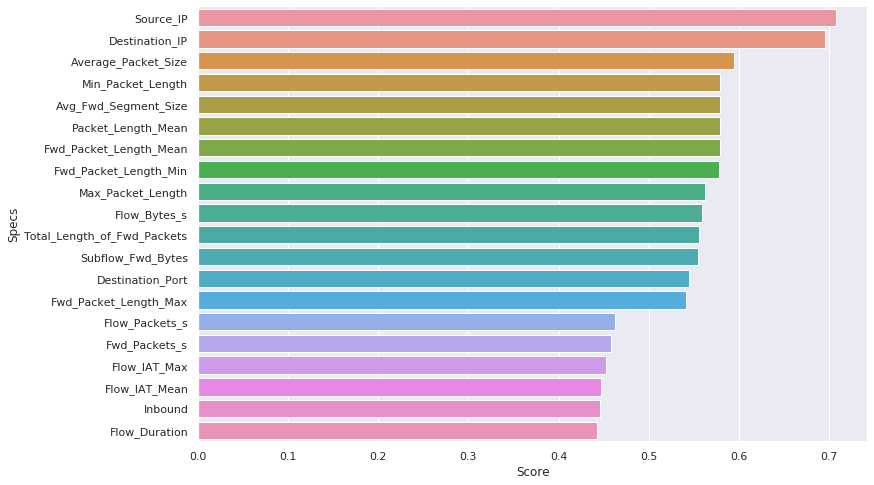

In [24]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(data = featureScores.nlargest(20,'Score'), x = "Score", y = "Specs")

To choose a value of $k$ we must compare the performance of the model with classification report of serveral techniques. Now we focus on the different selection techniques

## Feature Correlation Method

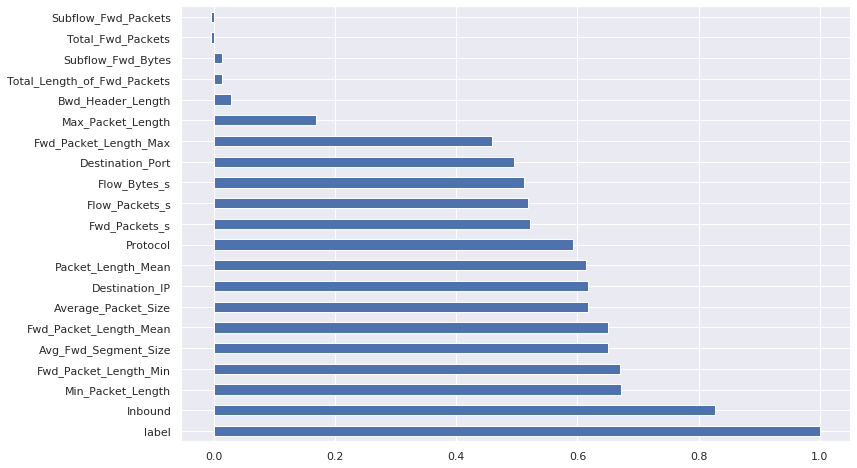

In [25]:
# determine 20 most correlated features
plt.figure(figsize=(12,8))
data_corr_label = data.corr()['label'].sort_values(ascending=False).head(21)
top_corr_features = data_corr_label.index
# plot top 20 most correlated features to our target (HEALTH)
data_corr_label.plot(kind='barh')
plt.show()

In [26]:
print(data_corr_label)

label                          1.000000
Inbound                        0.826326
Min_Packet_Length              0.672549
Fwd_Packet_Length_Min          0.670217
Avg_Fwd_Segment_Size           0.650285
Fwd_Packet_Length_Mean         0.650285
Average_Packet_Size            0.616972
Destination_IP                 0.616849
Packet_Length_Mean             0.614588
Protocol                       0.592556
Fwd_Packets_s                  0.522371
Flow_Packets_s                 0.519047
Flow_Bytes_s                   0.511427
Destination_Port               0.494880
Fwd_Packet_Length_Max          0.459225
Max_Packet_Length              0.167869
Bwd_Header_Length              0.027629
Total_Length_of_Fwd_Packets    0.012894
Subflow_Fwd_Bytes              0.012894
Total_Fwd_Packets             -0.004159
Subflow_Fwd_Packets           -0.004159
Name: label, dtype: float64


# Embedded Method

**Definition**
Embedded methods complete the feature selection process within the construction of the machine learning algorithm itself. In other words, they perform feature selection during the model training, which is why we call them embedded methods.

A learning algorithm takes advantage of its own variable selection process and performs feature selection and classification/regression at the same time.

**Advantages**
The embedded method solves both issues we encountered with the filter and wrapper methods by combining their advantages. Here’s how:
- They take into consideration the interaction of features like wrapper methods do.
- They are faster like filter methods.
- They are more accurate than filter methods.
- They find the feature subset for the algorithm being trained.
- They are much less prone to overfitting.

### Tree-based feature importance

Tree-based algorithms and models (i.e. random forest) are well-established algorithms that not only offer good predictive performance but can also provide us with what we call feature importance as a way to select features.

**Feature importance**

Feature importance tells us which variables are more important in making accurate predictions on the target variable/class. In other words, it identifies which features are the most used by the machine learning algorithm in order to predict the target.

#### Extra Tree Classifier 

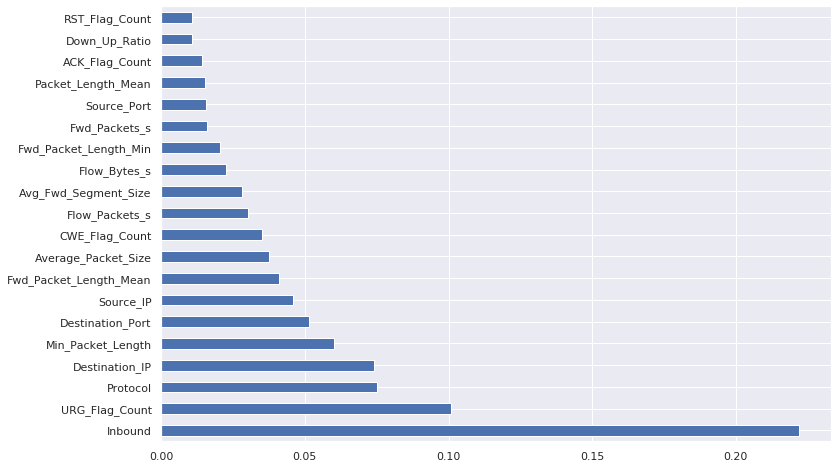

In [27]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,y)
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

#### RandomForest Classifier

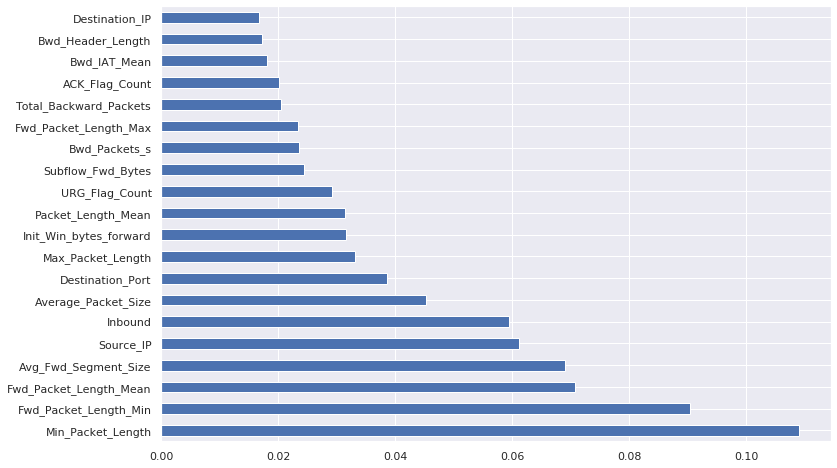

In [28]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X,y)
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

### Feature Selection via SelectFromModel

In [29]:
from sklearn.linear_model import Lasso, LogisticRegression

In [30]:
sfm_selector = SelectFromModel(estimator = RandomForestClassifier())
sfm_selector.fit(X, y)
X.columns[sfm_selector.get_support()]

Index(['Source_IP', 'Destination_IP', 'Destination_Port', 'Protocol',
       'Total_Backward_Packets', 'Total_Length_of_Fwd_Packets',
       'Fwd_Packet_Length_Max', 'Fwd_Packet_Length_Min',
       'Fwd_Packet_Length_Mean', 'Bwd_Header_Length', 'Bwd_Packets_s',
       'Min_Packet_Length', 'Packet_Length_Mean', 'ACK_Flag_Count',
       'URG_Flag_Count', 'Average_Packet_Size', 'Avg_Fwd_Segment_Size',
       'Subflow_Fwd_Bytes', 'Subflow_Bwd_Packets', 'Init_Win_bytes_forward',
       'Inbound'],
      dtype='object')

In [31]:
sfm_selector = SelectFromModel(estimator = LogisticRegression(C=1, penalty='l2'))
sfm_selector.fit(X, y)
X.columns[sfm_selector.get_support()]

Index(['Flow_Duration', 'Flow_Packets_s', 'Flow_IAT_Mean', 'Flow_IAT_Std',
       'Flow_IAT_Max', 'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Max',
       'Bwd_IAT_Total', 'Bwd_IAT_Mean', 'Bwd_IAT_Std', 'Bwd_IAT_Max',
       'Bwd_Header_Length', 'Fwd_Packets_s', 'Active_Mean', 'Active_Max',
       'Active_Min', 'Idle_Mean', 'Idle_Max', 'Idle_Min'],
      dtype='object')

# Wrapper Methods

**Definition**

Wrapper methods work by evaluating a subset of features using a machine learning algorithm that employs a search strategy to look through the space of possible feature subsets, evaluating each subset based on the quality of the performance of a given algorithm.

These methods are called greedy algorithms because they aim to find the best possible combination of features that result in the best performant model— which will be computationally expensive, and often impractical in the case of exhaustive search.

Practically any combination of a search strategy and a machine learning algorithm can be used as a wrapper.

**Advantages**

Given the issues we encountered using filter methods, wrapper methods present two main advantages that deal with those issues:

- They detect the interaction between variables
- They find the optimal feature subset for the desired machine learning algorithm

The wrapper methods usually result in better predictive accuracy than filter methods.

## Recursive Feature Elimination

In [33]:
rfe_selector = RFE(estimator=RandomForestClassifier(),n_features_to_select = 20, step = 1)
rfe_selector.fit(X,y)

RFE(estimator=RandomForestClassifier(), n_features_to_select=20)

In [ ]:
print(X.loc[:,rfe_selector.support_].columns.to_numpy())

## Sequential Feature Selection (SFS)

Source: https://heartbeat.comet.ml/hands-on-with-feature-selection-techniques-an-introduction-1d8dc6d86c16 

# Hybrid methods

## Filter + Embedded

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, RFE, SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Select top 2 features based on f_classif
selector = SelectKBest(f_classif, k = 25).fit(X, y)
dfscores = pd.DataFrame(selector.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
preselect_feature = featureScores.nlargest(25,'Score')['Specs'].to_list()

In [ ]:
plt.figure(figsize=(12,8))
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X[preselect_feature],y)
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X[preselect_feature].columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [ ]:
print(feat_importances.nlargest(20).index.to_list())

In [ ]:
#Select top 2 features based on mutual_info
selector = SelectKBest(f_classif, k = 25).fit(X, y)
dfscores = pd.DataFrame(selector.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
preselect_feature = featureScores.nlargest(25,'Score')['Specs'].to_list()

In [ ]:
plt.figure(figsize=(12,8))
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X[preselect_feature],y)
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X[preselect_feature].columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [ ]:
print(feat_importances.nlargest(20).index.to_list())

## Filter + Wrapper 

In [ ]:
#Select top 2 features based on f_classif
selector = SelectKBest(f_classif, k = 25).fit(X, y)
dfscores = pd.DataFrame(selector.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
preselect_feature = featureScores.nlargest(25,'Score')['Specs'].to_list()

In [ ]:
rfe_selector = RFE(estimator=RandomForestClassifier(),n_features_to_select = 20, step = 1)
rfe_selector.fit(X[preselect_feature],y)
print(X[preselect_feature].loc[:,rfe_selector.support_].columns.to_list())

In [ ]:
#Select top 2 features based on mutual_info
selector = SelectKBest(f_classif, k = 25).fit(X, y)
dfscores = pd.DataFrame(selector.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
preselect_feature = featureScores.nlargest(25,'Score')['Specs'].to_list()

In [ ]:
rfe_selector = RFE(estimator=RandomForestClassifier(),n_features_to_select = 20, step = 1)
rfe_selector.fit(X[preselect_feature],y)
print(X[preselect_feature].loc[:,rfe_selector.support_].columns.to_list())

## Embedded + Wrapper

In [ ]:
plt.figure(figsize=(12,8))
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,y)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.show()

In [ ]:
feature_preselect = feat_importances.nlargest(25).index.to_list()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
rfe_selector = RFE(estimator=DecisionTreeClassifier(),n_features_to_select = 20, step = 1)
rfe_selector.fit(X[feature_preselect],y)
print(X[feature_preselect].loc[:,rfe_selector.support_].columns.to_list())

# SHAP

In [ ]:
import shap
import xgboost as xgb
import lightgbm

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)   

In [ ]:
xgb_model = xgb.train({'objective':'binary:logitraw'}, xgb.DMatrix(X_train, label=y_train))
#xgb_model = xgb.train({'objective':'binary:logistic'}, xgb.DMatrix(X_train, label=y_train))

In [ ]:
# Tree on XGBoost
explainerXGB = shap.TreeExplainer(xgb_model)
shap_values_XGB_test = explainerXGB.shap_values(X_test)
shap_values_XGB_train = explainerXGB.shap_values(X_train)

In [ ]:
# XGBoost
df_shap_XGB_test = pd.DataFrame(shap_values_XGB_test, columns=X_test.columns.values)
df_shap_XGB_train = pd.DataFrame(shap_values_XGB_train, columns=X_train.columns.values)

In [ ]:
# j will be the record we explain
j = 0
# initialize js for SHAP
shap.initjs()

In [ ]:
shap.force_plot(explainerXGB.expected_value, shap_values_XGB_test[j], X_test.iloc[[j]])

In [ ]:
shap.summary_plot(shap_values_XGB_train, X_train, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values_XGB_train, X_train)